In [56]:
import pandas as pd
from collections import Counter, defaultdict
import itertools
import random
import matplotlib.pyplot as plt
import more_itertools
import seaborn as sns

In [57]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import brown
import re
from sklearn.feature_extraction import text## Stop words list

In [58]:
from sklearn.metrics.pairwise import cosine_similarity

# Clay's Contribution
## 0. Pre-Processing - Remove Stop Words and Tokenize

In [91]:
df_raw = pd.read_csv("../joined_data.csv")
df_raw.drop(['Unnamed: 0','Unnamed: 5', 'Unnamed: 6'], 1, inplace=True)

C:\Users\18438\AppData\Local\Temp/ipykernel_25708/3914969834.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_raw.drop(['Unnamed: 0','Unnamed: 5', 'Unnamed: 6'], 1, inplace=True)


In [92]:
print(f"{len(df_raw)} \t Total Rows")
print(f"{len(df_raw.drop_duplicates())} \t Total Non-Duplicate Rows")
print(f"{len(df_raw.drop_duplicates(subset = ['cleaned_song', 'cleaned_band']))} \t Total Rows of Non-Duplicate Band/Songs")
df = df_raw.drop_duplicates(subset=['cleaned_song', 'cleaned_band'])

142643 	 Total Rows
140323 	 Total Non-Duplicate Rows
94117 	 Total Rows of Non-Duplicate Band/Songs


In [93]:
i = text.ENGLISH_STOP_WORDS
j = list(",.!#[]/'")

stopwords = set(i).union(j)

In [94]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', str(x).lower()) # COMMENT: semi-equivalent to Baharks code: x.strip(",.!#[];\"\"\/\'\\()!?$*+-><_~1234567890&:=^`")
    x = [w for w in x.split() if w not in stopwords]
    
    return ' '.join(x) or None

In [96]:
df['cleaned_lyrics'] = df.apply(lambda x: preprocess(x.Lyrics), axis = 1)
df.dropna(subset=['cleaned_lyrics'], inplace=True)

C:\Users\18438\AppData\Local\Temp/ipykernel_25708/2977327710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_lyrics'] = df.apply(lambda x: preprocess(x.Lyrics), axis = 1)
C:\Users\18438\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [97]:
df['cleaned_lyrics'].head(10)

0     watch leaves fall ground suddenly belled sun c...
1     ill let burn words dirty paper cup im gonna tu...
2     quando ero piccolo tutti mi sherzavano le dime...
4     parcheggi abusivi applausi abusivi villette ab...
5     ontem manh quando acordei olheia vida e espant...
6     eu quero uma casa campo onde eu possa compor m...
8     madalena o meu peite percebeu que o mar uma go...
14    basta clamares inocncia eu sei todo o mal que ...
15    h muito tempo nas guas da guanabara o drago ma...
16    let start believing let hold hand let touch wa...
Name: cleaned_lyrics, dtype: object

## 1. Remove Non-English Songs

In [98]:
english_words = set(brown.words()) ## Cache

def classify_english_songs(lyrics):
    unique_words = set(lyrics.split())
    sample_size = min(50, len(unique_words))
    listed_lyrics = random.sample(set(lyrics.split()), sample_size)
    english_lyrics = [w for w in listed_lyrics if w in english_words]
    
    return len(english_lyrics)/sample_size
   
df['english_percentage'] = df.apply(lambda x: classify_english_songs(x.cleaned_lyrics), axis = 1)

C:\Users\18438\AppData\Local\Temp/ipykernel_25708/2950660547.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  listed_lyrics = random.sample(set(lyrics.split()), sample_size)
C:\Users\18438\AppData\Local\Temp/ipykernel_25708/2950660547.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['english_percentage'] = df.apply(lambda x: classify_english_songs(x.cleaned_lyrics), axis = 1)


(array([  579.,  3474.,  1995.,   549.,   260.,   645.,  2728.,  9028.,
        38469., 36374.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

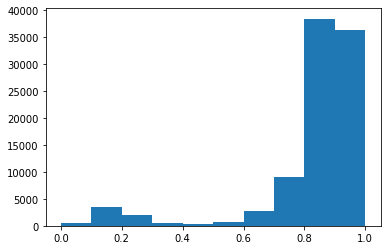

In [99]:
plt.hist(df['english_percentage'], 10)

In [100]:
#df[df['english_percentage'] < .6].to_csv("non_english_songs.csv", index=False)
print(f"Removed {len(df[df['english_percentage'] < .6])} Non-English Songs")
df = df[df['english_percentage'] > .6]

Removed 7343 Non-English Songs


## 2. Deduping song covers

In [101]:
#CASE 1: Two songs are the same (Count 5430)
song_dupes = df.groupby("cleaned_song").filter(lambda x: len(x) == 2) ##only keep songs that have one duplicate
print(len(song_dupes)/2)
song_dupes.sort_values("cleaned_song")

5183.0


,Band,cleaned_band,Lyrics,Song,cleaned_song,Column,title,cleaned_title,artist_name,cleaned_artist_name,duration,year,cleaned_lyrics,english_percentage
15427,Willie Nelson,willienelson,It was a $1000 wedding supposed to be held the...,$1000 wedding,1000wedding,460780,$ 1000 wedding,1000wedding,willie nelson,willienelson,185.02485,2006,wedding supposed held day invitations sent you...,0.940000
108095,Gram Parsons,gramparsons,"Was one thousand dollars wedding, supposed to ...",$1000 wedding,1000wedding,6154,$1000 wedding,1000wedding,gram parsons,gramparsons,303.17669,1974,thousand dollars wedding supposed held day inv...,0.880000
86778,Caliban,caliban,"A hundred suns, born to kill\nIt is madness, a...",100 suns,100suns,157595,100 suns (album version),100suns,caliban,caliban,236.27710,2004,suns born kill madness sun created man pervers...,0.870968
140335,30 Seconds to Mars,30secondstomars,I believe in nothing\nNot the end and not the ...,100 suns,100suns,273910,100 suns,100suns,30 seconds to mars,30secondstomars,117.49832,2009,believe end start believe earth stars believe ...,1.000000
75833,Young Dro,youngdro,Young Dro\nY'all already know what it is when ...,100 yard dash,100yarddash,223340,100 yard dash (featuring xtaci) (explicit albu...,100yarddash,young dro,youngdro,179.53914,2006,young dro yall know im ecstasy dis grand hustl...,0.640000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99517,David Bowie,davidbowie,"Yeah, yeah\nYeah, yeah\nYeah, yeah\nOh, yeah, ...",zeroes,zeroes,212730,zeroes (1999 digital remaster),zeroes,david bowie,davidbowie,344.45016,1987,yeah yeah yeah yeah yeah yeah oh yeah yeah you...,0.920000
29751,Kottonmouth Kings,kottonmouthkings,The war on drugs is a war on me and if its not...,zero tolerance,zerotolerance,337969,zero tolerance,zerotolerance,kottonmouth kings,kottonmouthkings,188.62975,2002,war drugs war let home brave land free just pl...,0.840000
18626,The Bluetones,thebluetones,"It was in those wonder-lust years, after I'd j...",zero tolerance,zerotolerance,418728,zero tolerance,zerotolerance,the bluetones,thebluetones,228.04853,2000,wonderlust years id just left school started n...,0.800000
89118,Tata Young,tatayoung,Zoom Zoom in under my skin\nGotta slow down no...,zoom,zoom,4403,zoom,zoom,tata young,tatayoung,198.47791,2006,zoom zoom skin gotta slow begin baby dont rush...,0.860000


In [102]:
shifted = song_dupes.sort_values("year").groupby('cleaned_song').shift(1)
song_dupes_comp = song_dupes.join(shifted.rename(columns=lambda x: x+"_lag")).sort_values("cleaned_song")
song_dupes_comp = song_dupes_comp[['cleaned_song', 'Lyrics', 'Lyrics_lag', 'cleaned_band', 'cleaned_band_lag', 'year', 'year_lag', 'cleaned_lyrics', 'cleaned_lyrics_lag']].dropna()

In [103]:
song_dupes_comp.sort_values("cleaned_song").head()

,cleaned_song,Lyrics,Lyrics_lag,cleaned_band,cleaned_band_lag,year,year_lag,cleaned_lyrics,cleaned_lyrics_lag
15427,1000wedding,It was a $1000 wedding supposed to be held the...,"Was one thousand dollars wedding, supposed to ...",willienelson,gramparsons,2006,1974.0,wedding supposed held day invitations sent you...,thousand dollars wedding supposed held day inv...
140335,100suns,I believe in nothing\nNot the end and not the ...,"A hundred suns, born to kill\nIt is madness, a...",30secondstomars,caliban,2009,2004.0,believe end start believe earth stars believe ...,suns born kill madness sun created man pervers...
108612,100yarddash,I tried to run but couldn't get too far\nMy he...,Young Dro\nY'all already know what it is when ...,raphaelsaadiq,youngdro,2008,2006.0,tried run far heart bumpin runnin place matter...,young dro yall know im ecstasy dis grand hustl...
80128,1015saturdaynight,10:15 on a Saturday night\nAnd the tap\nDrips ...,10.15\n10.15\nSaturday night\nSaturday night\n...,thelivingend,thecure,1998,1978.0,saturday night tap drips streetlight im sittin...,saturday night saturday night tap drips tap dr...
69907,11Jul,I met her at the 7-11\nNow I'm in seventh heav...,I met her at the 7-11\nNow I'm in seventh heav...,thepostmarks,ramones,2008,1981.0,met im seventh heaven tell tell true thought i...,met im seventh heaven tell tell true thought i...


In [ ]:
def one_hot_encoding(str_col: pd.Series,  max_features: int, ngram: str):
    """
    input:  str_col - pd.Series -> a column of strings
            ngram   - String    -> ngram option for bigrams
    output: tuple     -> np.SparseMatrix with one-hot-encoding representation, tokenized and joined list of strings
            ex. ([[1,0,1], [0,0,1]], ["red,blue","blue"])

    vectorizer.inverse_transform() returns a tokenized np.array of tokens.
    ex.  returns -> ['document,first,is,the,this',
             'document,is,second,the,this',
             'and,is,one,the,third,this',
             'document,first,is,the,this']
    """
    if ngram == "bigram":
        ngram_range = (2, 2)
    else:
        ngram_range = (1, 1)

    list_col = str_col.tolist()
    # COMMENT: could add token_pattern = r"\(.*?\)|([^\W_]+[^\s-]*)"
    # COMMENT: sklearn.CountVectorizer -> Removes stop words and punctuation and represents words as list of counts
    vectorizer = CountVectorizer(stop_words="english",
                                 binary=True,
                                 max_features=max_features,
                                 ngram_range=ngram_range).fit(list_col)

    x = vectorizer.transform(list_col)
    tokenized = [",".join(token_array) for token_array in vectorizer.inverse_transform(x.toarray())]

    return x, tokenized

In [104]:
def find_lyric_similarity(lyric1_col: pd.Series, lyric2_col: pd.Series):
    lyrics = pd.concat(
        [lyric1_col.reset_index(drop=True), lyric2_col.reset_index(drop=True)],
        ignore_index=True)
    encoded_lyrics = one_hot_encoding(lyrics, ngram='unigram', max_features = None)[0].toarray()

    lyrics_1 = encoded_lyrics[0:len(lyric1_col)]
    lyrics_2 = encoded_lyrics[len(lyric1_col):]

    cosine_scores = []
    for i in range(lyrics_1.shape[0]):
        score = cosine_similarity([lyrics_1[i]], [lyrics_2[i]])[0]
        cosine_scores.append(score)

    return cosine_scores

In [105]:
## COMMENT: True Covers
song_dupes_comp['score'] = find_lyric_similarity(song_dupes_comp['cleaned_lyrics'], song_dupes_comp['cleaned_lyrics_lag'])
song_dupes_comp[song_dupes_comp['score']>.95].head() ## COMMENT: 596 songs are actual covers

,cleaned_song,Lyrics,Lyrics_lag,cleaned_band,cleaned_band_lag,year,year_lag,cleaned_lyrics,cleaned_lyrics_lag,score
15427,1000wedding,It was a $1000 wedding supposed to be held the...,"Was one thousand dollars wedding, supposed to ...",willienelson,gramparsons,2006,1974.0,wedding supposed held day invitations sent you...,thousand dollars wedding supposed held day inv...,[0.9624999999999999]
69907,11Jul,I met her at the 7-11\nNow I'm in seventh heav...,I met her at the 7-11\nNow I'm in seventh heav...,thepostmarks,ramones,2008,1981.0,met im seventh heaven tell tell true thought i...,met im seventh heaven tell tell true thought i...,[1.0]
62314,1999,I was dreamin' when I wrote this\nForgive me i...,I was dreamin' when I wrote this\nForgive me i...,themikeflowerspops,prince,1996,1993.0,dreamin wrote forgive goes astray woke mornin ...,dreamin wrote forgive goes astray woke mornin ...,[0.9999999999999998]
29421,22steps,If I were him\nI'd know your birthday\nJust wh...,"If I were him,\nI'd know your birthday.\nJust ...",damienleith,andystochansky,2007,2002.0,id know birthday just colors wear wed buy old ...,id know birthday just colors wear wed buy old ...,[0.975304830396693]
132279,2hb,Oh I was moved by your screen dream\nCelluloid...,Oh I was moved by your screen dream\nCelluloid...,roxymusic,bryanferry,1995,1976.0,oh moved screen dream celluloid pictures livin...,oh moved screen dream celluloid pictures livin...,[1.0]


In [106]:
unique = df.merge(song_dupes_comp[song_dupes_comp['score']>.95], how='left')
print(f"Found {len(unique[~unique['Lyrics_lag'].isnull()])} Song Cover duplicates")
unique = unique[unique['Lyrics_lag'].isnull()]
len(unique)

Found 565 Song Cover duplicates


86034

### 2.2 Pre-Processing for Market Basket Analysis (MBA) - "only_popular_word" column

In [154]:
flatlist = [sublist.split() for sublist in unique['cleaned_lyrics'].tolist()]
flatlist = [item for sublist in flatlist for item in sublist]
## word count

word_count = dict(Counter(flatlist))
word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))

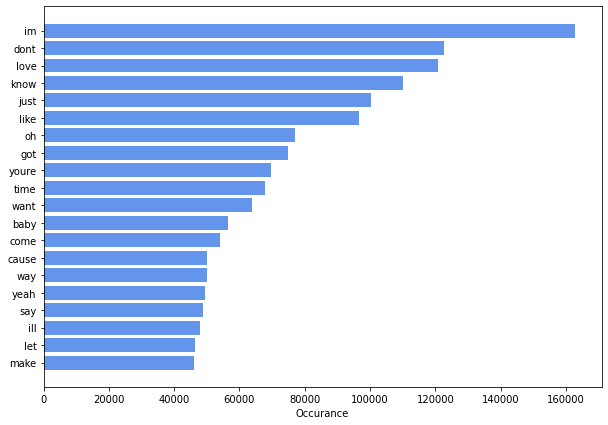

C:\Users\18438\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.8209

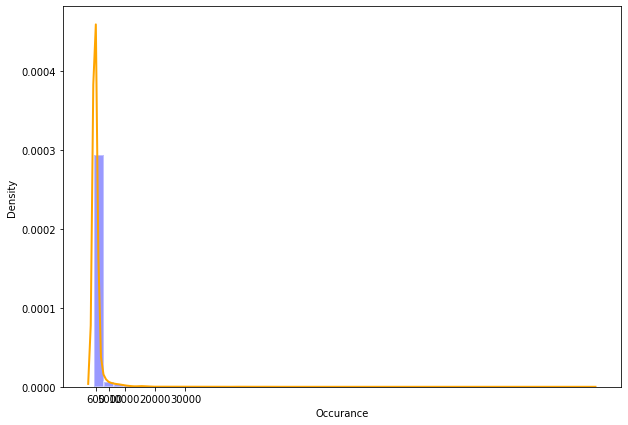

In [156]:
## For the perpouse of graph
## Top 20 words-First graph
pop_words_graph = more_itertools.take(20, word_count.items())
plt.figure(figsize=(10,7))
x_val = [x[0] for x in pop_words_graph]
y_val = [x[1] for x in pop_words_graph]
plt.barh(x_val,y_val, color='#6495ED')
plt.xlabel("Occurance")
plt.gca().invert_yaxis()
plt.rc('font', size=10) 
plt.show()


# Second graph
pop_words_graph = more_itertools.take(10000, word_count.items())
x = pd.Series([i[1] for i in pop_words_graph])
plt.figure(figsize=(10,7))
ax = sns.distplot(x, bins=50, kde=True, hist_kws=dict(color= "#0000FF", edgecolor="white", linewidth=2),\
                 kde_kws=dict(color= "orange", linewidth=2))
plt.xticks([600, 5000, 10000, 20000, 30000])
plt.xlabel("Occurance")


less_1000 = len([i for i in x if i<600])
less_1000/len(x)

In [157]:
## top 1200 words list is saved
## 1200 seems the good threshhold
pop_words_selected = more_itertools.take(1200, word_count.items())
pop_words_selected = [x[0] for x in pop_words_selected]

with open('word_list.csv', mode='w') as word_file:
    word_file = csv.writer(word_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    word_file.writerow(pop_words_selected)

In [169]:
    ## select lyrics that have the top words
def popular_words(row, popular):

        return [w for w in row.split() if w in popular]
    
unique['only_popular_word'] = unique.apply(lambda x: popular_words(x['cleaned_lyrics'], pop_words_selected), axis=1)

In [170]:
unique['only_popular_word'].head()

0    [watch, leaves, fall, ground, suddenly, sun, c...
1    [ill, let, burn, words, dirty, paper, cup, im,...
2    [let, start, let, hold, hand, let, touch, watc...
3    [time, turn, head, try, shake, say, baby, aint...
4    [explain, funny, feeling, deep, inside, makes,...
Name: only_popular_word, dtype: object

In [171]:
## Remove empty lists-meaning those lyrics dnt have the popular words
unique = unique[unique['only_popular_word'].map(lambda d: len(d)) > 0]
len(unique)

85801

## 3. Picking Anchor Words

In [172]:
#COMMENT: Models changed on different time-periods
period_1 = unique[unique['year'] <= 1983]
period_2 = unique[(unique['year'] > 1983) & (unique['year'] <=1991)]
period_3 = unique[(unique['year'] >= 1991)]

In [173]:
def get_top_n(flatlist, n):
    ## word count
    word_count = Counter(flatlist)
    word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))

    top_100 = list(word_count.keys())[0:(n-1)]
    
    return top_100
    
flat_p1 = list(itertools.chain(*[lyrics.split() for lyrics in period_1['cleaned_lyrics'].tolist()]))
flat_p2 = list(itertools.chain(*[lyrics.split() for lyrics in period_2['cleaned_lyrics'].tolist()]))
flat_p3 = list(itertools.chain(*[lyrics.split() for lyrics in period_3['cleaned_lyrics'].tolist()]))

top_100_p1 = get_top_n(flat_p1, 250)
top_100_p2 = get_top_n(flat_p2, 250)
top_100_p3 = get_top_n(flat_p3, 250)

top_i = 0
j = 0
top_100_words = []
while top_i < 100:
    if (top_100_p1[j] in top_100_p2) and (top_100_p1[j] in top_100_p2):
        top_100_words.append(top_100_p1[j])
        top_i+=1
    j += 1

X = set(top_100_p1).intersection(top_100_p2).intersection(top_100_p3)

In [174]:
sum([True for x in X if x in top_100_p1]) == sum([True for x in X if x in top_100_p2]) == sum([True for x in X if x in top_100_p3])

True

In [175]:
pd.DataFrame(top_100_words, columns = ["word"]).to_csv("top_100_words.csv", index= True) #Index represents the top i position

## 4. Co-Occurence (counted weighting)

In [176]:
## Flat list for periods
flatList_p1 = list(period_1["only_popular_word"])
flatList_p2 = list(period_2["only_popular_word"])
flatList_p3 = list(period_3["only_popular_word"])

In [177]:
## Cout co occurances in period 1

pair_counts = defaultdict(int)
def cooccurnace(pair_counts, items):
    """
    Updates a dictionary of pair counts for
    all pairs of items in a given itemset.
    """
    for i in items:
        for (a, b) in itertools.combinations(i, 2):
            pair_counts[(a, b)] += 1
            pair_counts[(b, a)] += 1

    return pair_counts

for i, period in enumerate([flatList_p1, flatList_p2, flatList_p3]):
    period1_matrix = sorted(cooccurnace(pair_counts, period).items(), key= lambda x:x[1], reverse=True)[1::2]

    ## Save the co-occurances
    with open(f'node_edge_p{i}.csv', mode ='w', newline ='') as word_file:
        word_file = csv.writer(word_file, delimiter=',')
        word_file.writerows(period1_matrix)


## 5. Co-Occurrence (MBA support weighting)

In [178]:
from apyori import apriori

In [180]:
for i, period in enumerate([flatList_p1, flatList_p2, flatList_p3]):
    algo = apriori(period, min_support=0.003, min_confidence=0.005, min_lift=2, max_length=2)
    results = list(algo)

    ## pd.DataFrame(results) and save
    association_rule_P1 = pd.DataFrame(results).sort_values(by=['support'], ascending=False)
    association_rule_P1.to_csv(f'association_rule_P{i}.csv')   

## 6. Bi-Grams with TF-IDF Weights

In [43]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

list_col = unique['cleaned_lyrics'].dropna().tolist()
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(2,2)).fit(list_col)

In [44]:
feature_names = tfidf.get_feature_names_out()

ts = time.time()
tfidf_matrix = tfidf.transform(list_col)
tfidf_dict = {}
te = time.time()
print(f"Takes {(te-ts)/60} minutes for the TF-IDF transform)

for i in range(tfidf_matrix.shape[0]):
    feature_index = tfidf_matrix[i, :].nonzero()[1]
    tfidf_scores = zip([feature_names[j] for j in feature_index], [tfidf_matrix[i, x] for x in feature_index])
    tfidf_dict.update(dict(tfidf_scores))

(array([1.718125e+06, 6.995110e+05, 1.082510e+05, 2.495000e+04,
        9.169000e+03, 4.203000e+03, 1.883000e+03, 8.120000e+02,
        1.830000e+02, 7.300000e+01]),
 array([0.00571965, 0.10514769, 0.20457572, 0.30400376, 0.40343179,
        0.50285983, 0.60228786, 0.7017159 , 0.80114393, 0.90057197,
        1.        ]),
 <BarContainer object of 10 artists>)

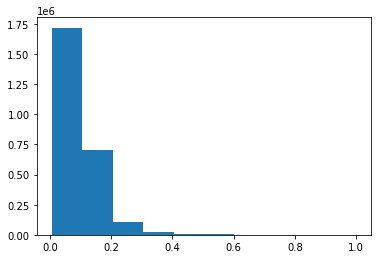

In [45]:
plt.hist(tfidf_dict.values(), 10)

In [46]:
love_dict = {bigram:score for bigram, score in tfidf_dict.items() if re.search(r"\blove\b", bigram)}
sorted(love_dict, key=love_dict.get)

## Top 10 words used adjacent to the word "love"
# 1. Record
# 2. Falling
# 3. Letter
# 4. Girls
# 5. Lose
# 6. Runway
# 7. Rump
# 8. Wobble
# 9. Strippaaa
# 10. Droc

['record love',
 'fallin love',
 'love letter',
 'ground love',
 'girls love',
 'love lose',
 'runway love',
 'rump love',
 'love wobble',
 'love strippaaa',
 'droc love',
 'clearaaa love',
 'love haters',
 'que love',
 'love shout',
 'love scoda',
 'loui love',
 'rubadub love',
 'love cuz',
 'shout love',
 'love gamblin',
 'whatsoever love',
 'vacuum love',
 'seh love',
 'love wow',
 'love cat',
 'rihanna love',
 'love perculating',
 'love pop',
 'love phase',
 'love perform',
 'apple love',
 'love huey',
 'cum love',
 'orchestration love',
 'oohwee love',
 'love spirituals',
 'love oasis',
 'love kismet',
 'love chickicken',
 'love juice',
 'dime love',
 'spm love',
 'skirts love',
 'seattle love',
 'oklahoma love',
 'mississippi love',
 'michigan love',
 'love boppers',
 'louisiana love',
 'latinas love',
 'htown love',
 'florida love',
 'filipinas love',
 'fahitas love',
 'beeshy love',
 'arizona love',
 'albuquerque love',
 'alabama love',
 'mils love',
 'crackin love',
 'love che

In [47]:
print(love_dict)
# VISUALIZATION This is what we would output to the visualization piece

{'love magic': 0.03690169592681063, 'love deep': 0.0645279204543672, 'deep love': 0.05086901530155282, 'love ya': 0.025891582731085383, 'know love': 0.03407402660284329, 'say love': 0.04006239987861149, 'people love': 0.15384471282705847, 'love somebody': 0.6438747336233345, 'love life': 0.07234846734931001, 'seek love': 0.07239008930093105, 'love ive': 0.13215850338107013, 'love body': 0.07596899614100198, 'falling love': 0.1281218426694941, 'love thought': 0.05584741893543152, 'kind love': 0.07927858334919025, 'love dressed': 0.07301343906402681, 'free love': 0.08114655808891272, 'till love': 0.05179747977242141, 'mean love': 0.05610984400862717, 'love safe': 0.04140617646154785, 'love ending': 0.08326618450704738, 'thats love': 0.045505015184043686, 'pride love': 0.05906758045833947, 'love stronger': 0.12565277218495796, 'love love': 0.06787119171115162, 'love deeper': 0.07268089414512759, 'love come': 0.05636507752777124, 'knew love': 0.12276416487974823, 'deeper love': 0.029642100

In [156]:
pop_words = ['love',
'time',
'feel',
'life',
'day',
'heart',
'night',
'eyes',
'baby',
'yeah'
]
bigram_df = pd.DataFrame(columns = ['bigram', 'score'])

def get_bigram_df(bigram_scores):
    return pd.DataFrame.from_dict(bigram_scores, orient='index')\
        .reset_index()\
        .rename(columns={"index": "bigram", 0: "score"})\
        .sort_values('score', ascending=False)[0:10]

for word in pop_words:
    regular_expr = r"\b" + re.escape(word) + r"\b"
    bigram_dict = {bigram:score for bigram, score in tfidf_dict.items() if re.search(regular_expr, bigram)}
    bigram_df = pd.concat([bigram_df, get_bigram_df(bigram_dict)], axis = 0)

In [160]:
bigram_df["word_1"] = bigram_df.apply(lambda x: x['bigram'].split()[0], axis = 1)
bigram_df["word_2"] = bigram_df.apply(lambda x: x['bigram'].split()[1], axis = 1)

bigram_df[["word_1", "word_2", "score"]].to_csv("../bigram_results.csv", index=False)

## 7. kNN - Cosine Similarity of Word2Vec Vectors

In [54]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [56]:
lyric_list = [song_lyrics.split() for song_lyrics in unique['cleaned_lyrics'].tolist()]

In [60]:
token_count = sum([len(lyrics) for lyrics in lyric_list])

In [61]:
token_count

1113842

In [71]:
## LINK: https://radimrehurek.com/gensim/models/word2vec.html
lyric_list = [song_lyrics.split() for song_lyrics in period_1['cleaned_lyrics'].tolist()]
model = Word2Vec(sentences=lyric_list, vector_size=300, window=5, min_count=1, workers=4)

print(f"Takes {(te-ts)/60} minutes for the Word2Vec Training Model")
model.wv.most_similar('hate', topn=10)

Takes 0.09387737115224203 minutes for the TF-IDF transform


[('gripe', 0.510608971118927),
 ('mouch', 0.5105478763580322),
 ('unexpressed', 0.5025018453598022),
 ('distrust', 0.49721428751945496),
 ('anothers', 0.48299723863601685),
 ('clipped', 0.45881274342536926),
 ('war', 0.45338916778564453),
 ('panorama', 0.44405725598335266),
 ('having', 0.44333139061927795),
 ('sin', 0.4380272626876831)]

In [72]:
period_1_lyric_list = [song_lyrics.split() for song_lyrics in period_1['cleaned_lyrics'].tolist()]

ts = time.time()
model.train(period_1_lyric_list, total_examples=1113842, epochs=model.epochs)
te = time.time()
model.wv.most_similar('hate', topn=10) #first period

[('gripe', 0.4716223180294037),
 ('distrust', 0.45679518580436707),
 ('clipped', 0.45359885692596436),
 ('mouch', 0.4478950500488281),
 ('panorama', 0.4472619593143463),
 ('unforseeen', 0.4229658842086792),
 ('tradition', 0.41912364959716797),
 ('unexpressed', 0.4025311768054962),
 ('anothers', 0.3999611735343933),
 ('gino', 0.3931879997253418)]

VISUALIZATION: Our results for the visuzliation then would be for example:
    (love, gripe), 0.47162

In [73]:
period_2_lyric_list = [song_lyrics.split() for song_lyrics in period_2['cleaned_lyrics'].tolist()]

ts = time.time()
model.train(period_2_lyric_list, total_examples=1113842, epochs=model.epochs)
te = time.time()
model.wv.most_similar('hate', topn=10) #first period

[('mouch', 0.4211888611316681),
 ('gripe', 0.41791772842407227),
 ('panorama', 0.4064144194126129),
 ('ignorance', 0.3967815637588501),
 ('hypnosis', 0.3964284658432007),
 ('hatred', 0.3841608762741089),
 ('despise', 0.37812334299087524),
 ('clipped', 0.37051478028297424),
 ('fear', 0.36486420035362244),
 ('destruction', 0.3415083587169647)]

In [74]:
period_3_lyric_list = [song_lyrics.split() for song_lyrics in period_3['cleaned_lyrics'].tolist()]

ts = time.time()
model.train(period_3_lyric_list, total_examples=1113842, epochs=model.epochs)
te = time.time()
model.wv.most_similar('hate', topn=10) #first period

[('despise', 0.43800005316734314),
 ('escalate', 0.3843837082386017),
 ('envy', 0.37842923402786255),
 ('relate', 0.3716249167919159),
 ('jealousy', 0.3675151467323303),
 ('anger', 0.35160019993782043),
 ('affecting', 0.342942476272583),
 ('hated', 0.3353613018989563),
 ('love', 0.3333044648170471),
 ('fate', 0.3310360014438629)]

In [154]:
## LINK: https://radimrehurek.com/gensim/models/word2vec.html
lyric_list = [song_lyrics.split() for song_lyrics in period_1['cleaned_lyrics'].tolist()]
model = Word2Vec(sentences=lyric_list, vector_size=300, window=5, min_count=1, workers=4)

print(f"Takes {(te-ts)/60} minutes for the Word2Vec Training Model")

word2vec_df = pd.DataFrame(columns=['word_1', 'word_2', 'score'])
for word in pop_words:
    word2vec_top = model.wv.most_similar(word, topn=10)
    w2v_df = pd.DataFrame(word2vec_top, columns=['word_2', 'score'])
    w2v_df['word_1'] = word
    word2vec_df = pd.concat([word2vec_df, w2v_df])

Takes 0.5796539187431335 minutes for the Word2Vec Training Model


In [158]:
word2vec_df.to_csv("../word2vec_df.csv", index=False)